In [1]:
import time
start = time.perf_counter()

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier

In [5]:
np.random.seed(903967645)
default_payment_dataset = pd.read_csv('../data/default_of_credit_card_clients.csv', header=1)
print(default_payment_dataset.info())
default_payment_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Check shape of dataset and for null data
print(default_payment_dataset.shape)
default_payment_dataset.isna().any().any()

(30000, 25)


False

In [7]:
print(default_payment_dataset.columns)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [8]:
# Separate features and target
train_X = default_payment_dataset.drop(columns=['ID', 'default payment next month'])
train_y = default_payment_dataset['default payment next month']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)

In [9]:
%%time
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_X, train_y):
    strat_train_set = train_X.iloc[train_index]
    strat_test_set = train_X.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X = strat_train_set
test_X = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 13 ms, sys: 5.22 ms, total: 18.2 ms
Wall time: 15.4 ms


In [10]:
print(test_X)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  \
6907    0.040404  0.0   0.333333  0.666667  0.431034    0.1    0.1    0.1   
24575   0.141414  0.0   0.166667  0.333333  0.172414    0.1    0.1    0.0   
26766   0.040404  0.0   0.333333  0.666667  0.068966    0.2    0.2    0.2   
2156    0.282828  1.0   0.166667  0.666667  0.068966    0.2    0.2    0.2   
3179    0.494949  1.0   0.333333  0.333333  0.103448    0.0    0.0    0.0   
...          ...  ...        ...       ...       ...    ...    ...    ...   
8836    0.141414  1.0   0.833333  0.666667  0.103448    0.0    0.0    0.1   
1259    0.040404  0.0   0.166667  0.666667  0.051724    0.4    0.4    0.2   
27309   0.212121  0.0   0.166667  0.666667  0.224138    0.2    0.2    0.1   
29583   0.111111  0.0   0.166667  0.666667  0.086207    0.1    0.1    0.1   
24399   0.191919  0.0   0.500000  0.666667  0.206897    0.0    0.0    0.0   

       PAY_4  PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
690

In [ ]:
%%time
# Initialize and train the neural network
neural_net = MLPClassifier(random_state=42)
neural_net.fit(train_X, train_y)

In [11]:
%%time
# Evaluate on training data
train_predictions = neural_net.predict(train_X)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/credit-nn/training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.8240416666666667
Training ROC AUC Score: 0.6651902677239853
Training Precision: 0.6839430894308943
Training Recall: 0.3802976078357506
Training F1 Score: 0.48880280837670986
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     18691
           1       0.68      0.38      0.49      5309

    accuracy                           0.82     24000
   macro avg       0.76      0.67      0.69     24000
weighted avg       0.81      0.82      0.80     24000

CPU times: user 239 ms, sys: 399 ms, total: 638 ms
Wall time: 72.6 ms


In [12]:
%%time
# Evaluate testing data
test_predictions = neural_net.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/credit-nn/testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.8186666666666667
Testing ROC AUC Score: 0.6591195295135308
Testing Precision: 0.6591211717709721
Testing Recall: 0.3730218538055765
Testing F1 Score: 0.4764196342637151
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

CPU times: user 274 ms, sys: 15.7 ms, total: 289 ms
Wall time: 33.8 ms


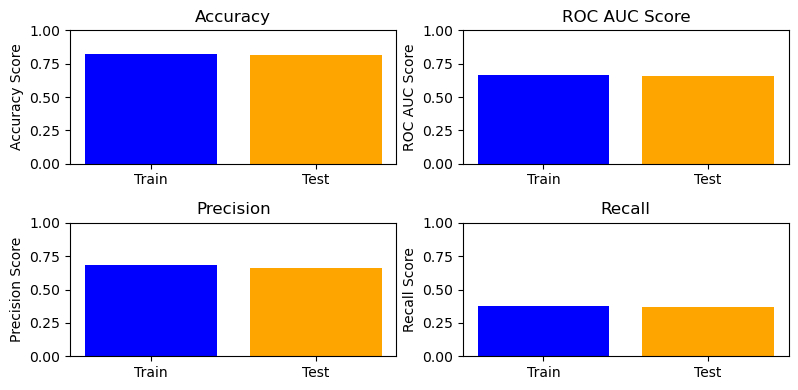

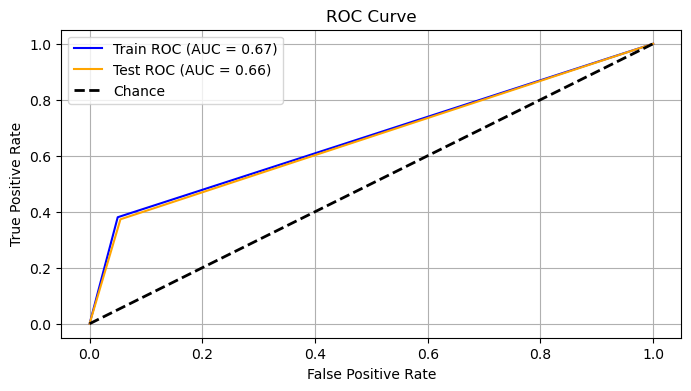

CPU times: user 1.27 s, sys: 1.12 s, total: 2.39 s
Wall time: 347 ms


In [13]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/credit-nn/metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/credit-nn/roc-curve')
plt.show()



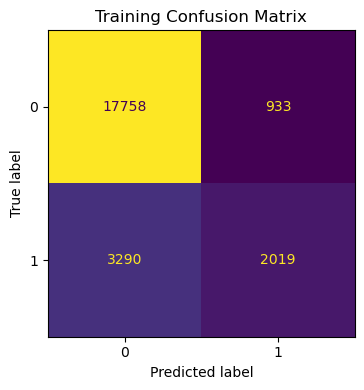

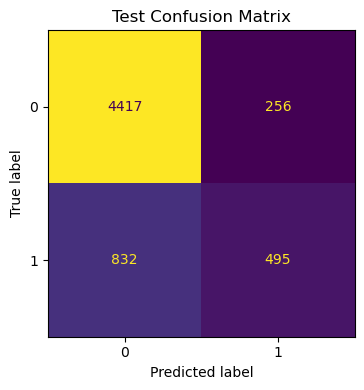

CPU times: user 361 ms, sys: 7.42 ms, total: 368 ms
Wall time: 123 ms


In [14]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/credit-nn/training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/credit-nn/testing-cm.png')
plt.show()

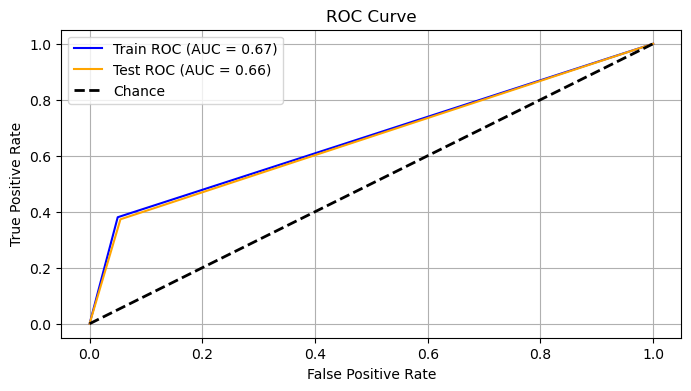

CPU times: user 324 ms, sys: 7.39 ms, total: 331 ms
Wall time: 116 ms


In [15]:
%%time
# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/credit-nn/roc-curve-fpr-tpr.png')
plt.show()

Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

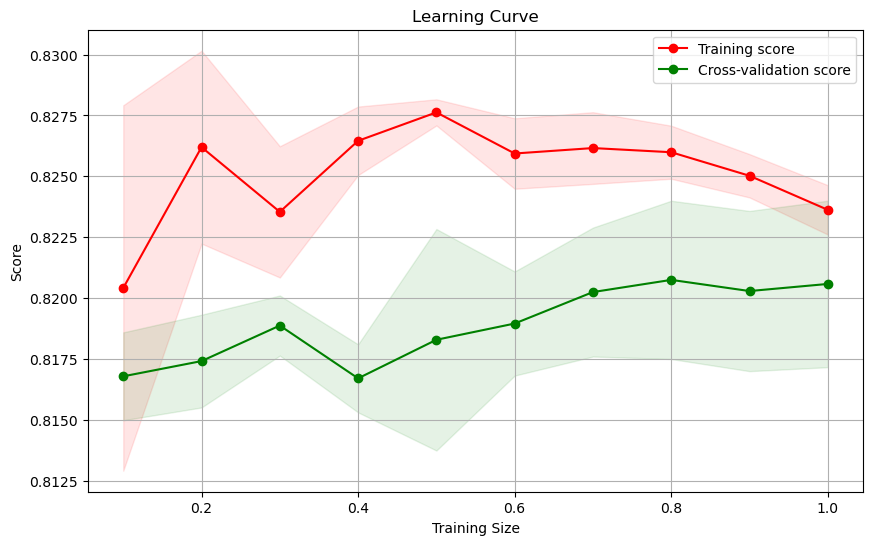

CPU times: user 4h 26min 46s, sys: 15min 36s, total: 4h 42min 22s
Wall time: 49min 13s


In [16]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/credit-nn/learning-curve-training-size.png')
plt.show()

Validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

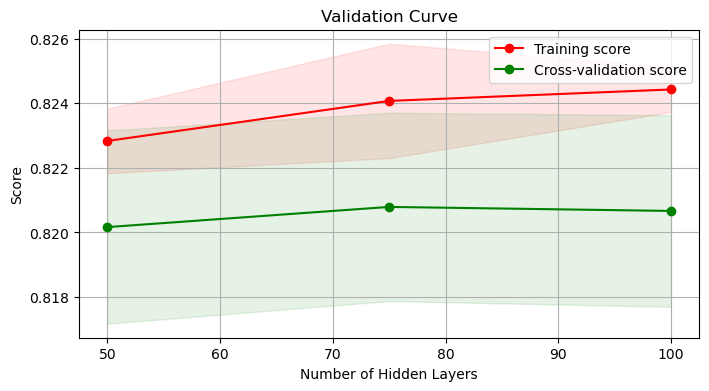

CPU times: user 283 ms, sys: 1.11 s, total: 1.4 s
Wall time: 14.7 s


In [17]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/credit-nn/validation-curve-hidden-layers.png')
plt.show()

Validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

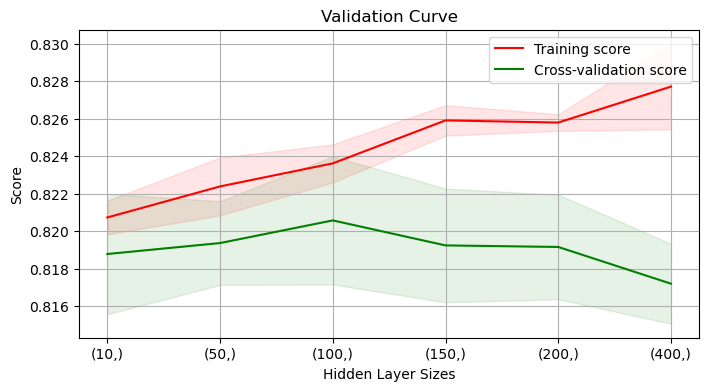

CPU times: user 655 ms, sys: 345 ms, total: 1 s
Wall time: 42.7 s


In [18]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/credit-nn/validation-curve-hidden-layer-sizes-2.png')
plt.show()

Validation progress:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


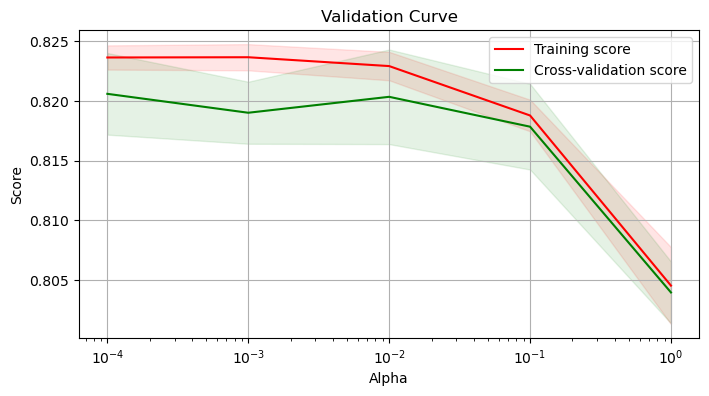

CPU times: user 1 s, sys: 43.3 ms, total: 1.05 s
Wall time: 18.4 s


In [19]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X, train_y, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/credit-nn/validation-curve-alpha.png')
plt.show()

In [20]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(neural_net, train_X, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/credit-nn/cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.80875    0.82166667 0.83583333 0.81041667 0.81291667 0.8275
 0.81375    0.82166667 0.82458333 0.81791667]
mean cross-validation score: 0.8194999999999999
CPU times: user 57min 55s, sys: 1min 9s, total: 59min 5s
Wall time: 6min 43s


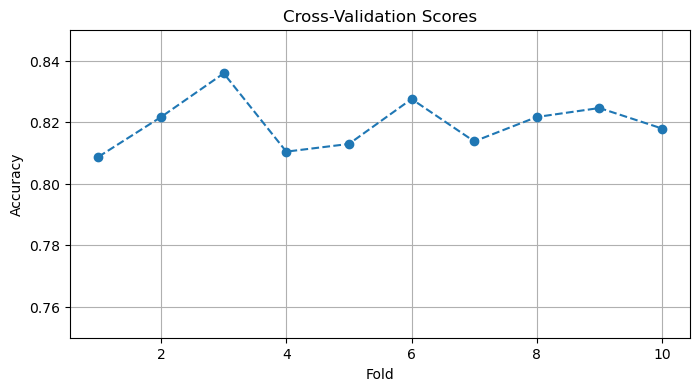

In [21]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/credit-nn/cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     18691
           1       0.66      0.38      0.48      5309

    accuracy                           0.82     24000
   macro avg       0.75      0.66      0.69     24000
weighted avg       0.80      0.82      0.80     24000



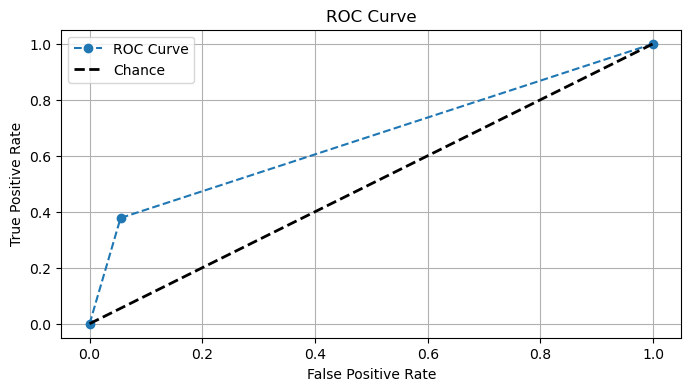

CPU times: user 17min 57s, sys: 36.6 s, total: 18min 33s
Wall time: 1min 57s


In [22]:
%%time
y_pred = cross_val_predict(neural_net, train_X, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/credit-nn/classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/credit-nn/roc-curve-fpr.png')
plt.show()

In [23]:
%%time
# Hyperparameter tuning using GridSearchCV with increased max_iter
param_grid = {
    'hidden_layer_sizes': [(50,), (75,), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['adaptive'],
    'max_iter': [50, 100, 200],
}

mlp = MLPClassifier()
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=2)
grid_search.fit(train_X, train_y)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Write the best parameters and best score to a text file
with open('../results/credit-nn/grid_search_results.txt', 'w') as file:
    file.write("Best parameters found: " + str(grid_search.best_params_) + "\n")
    file.write("Best cross-validation score: " + str(grid_search.best_score_) + "\n")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   1.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=100, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=100, solver=adam; total time

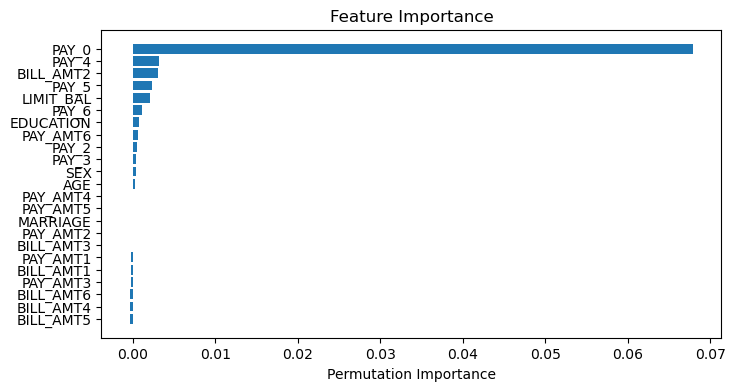

CPU times: user 2min 8s, sys: 4.83 s, total: 2min 13s
Wall time: 16.3 s


In [24]:
%%time
# Fit the model with the best found parameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(train_X, train_y)

# Calculate feature importance
result = permutation_importance(best_mlp, test_X, test_y, n_repeats=10, random_state=42, n_jobs=1)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 4))
plt.barh(train_X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.savefig('../images/credit-nn/feature-importance.png')
plt.show()

In [11]:
%%time
# Assuming train_X, train_y, test_X, test_y are already defined
best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=200,
    solver='adam'
)
best_mlp.fit(train_X, train_y)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, train_X, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

test_predictions = best_mlp.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
# plt.figure(figsize=(8, 4))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# plt.title('F1_weighted score learning curve')
# plt.xlabel('Number of Training Instances Used')
# plt.ylabel('Score')
# plt.legend(loc="best")
# plt.grid()
# plt.savefig('../images/credit-nn/best-nn-training-vs-test-set')
# plt.show()
# # Write to a text file
# with open('../results/credit-nn/test_classification_results.txt', 'w') as file:
#     file.write("Classification Report:\n")
#     file.write(test_report + "\n")
#     file.write("Confusion Matrix:\n")
#     file.write(np.array2string(test_cm) + "\n")

/Users/xavierelon/miniconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

Testing Accuracy: 0.8183333333333334
Testing ROC AUC Score: 0.6656503368531017
Testing Precision: 0.6475716064757161
Testing Recall: 0.3918613413715147
Testing F1 Score: 0.48826291079812206
CPU times: user 1min 39s, sys: 2.61 s, total: 1min 42s
Wall time: 29.7 s


/Users/xavierelon/miniconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 101.45718713403333
